**Our main goal:** Train very simple baseline CNN model on MNIST digits dataset. By analyzing the failed casses, retrain the model with cleaned data and compare results.

Importing libraries

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # To run on CPU uncomment this
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
import numpy as np
import math
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

Preparing our data (MINST digits dataset)

In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"min = {np.min(x_train)}")
print(f"max = {np.max(x_train)}")
print(f"mean = {np.mean(x_train)}")
print(f"initial x_train.shape = {x_train.shape}")
print(f"initial y_train.shape = {y_train.shape}")

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("y_train shape:", y_train.shape)

11501568/11490434 [==============================] - 0s 0us/step
min = 0
max = 255
mean = 33.318421449829934
initial x_train.shape = (60000, 28, 28)
initial y_train.shape = (60000,)
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 10)


Defining our models

In [4]:
def get_baseline_model():
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, kernel_size=(3, 3))(inputs) 
    x = layers.BatchNormalization()(x) #Added batchnorm
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3))(x) 
    x = layers.BatchNormalization()(x) #Added batchnorm
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs)
    
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256   

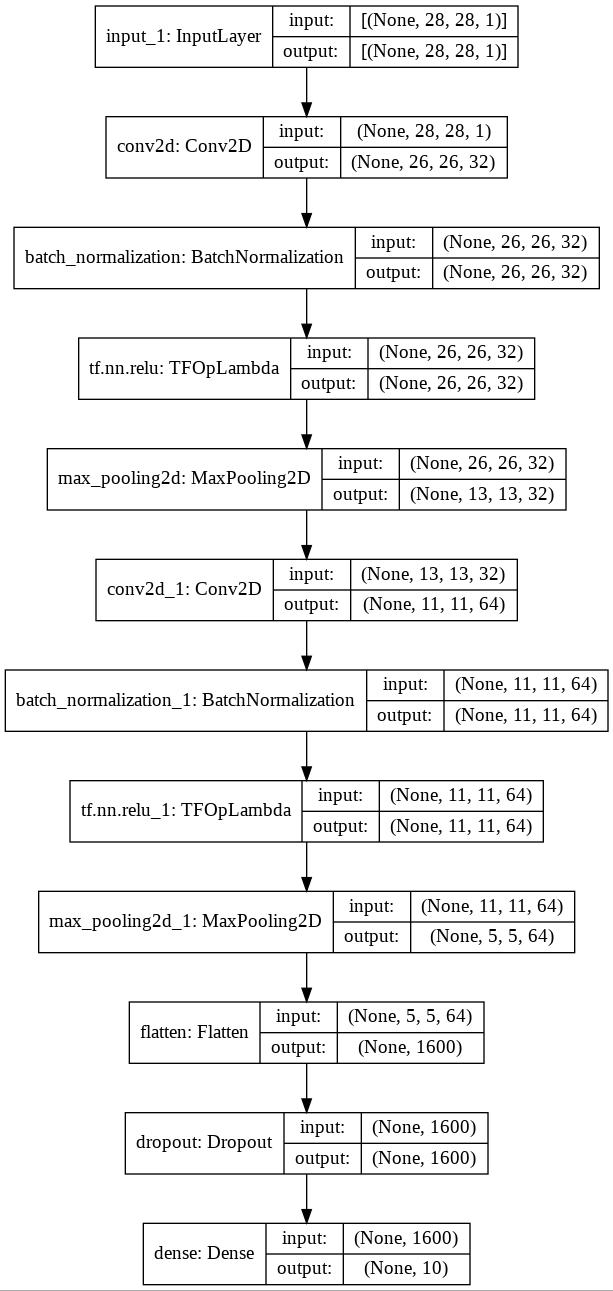

In [5]:
tf.random.set_seed(42)

model = get_baseline_model()
model.summary()
keras.utils.plot_model(model, to_file="single_head.jpg",
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       dpi=96)

Compiling the base model

In [5]:
optimizer = keras.optimizers.Adam(learning_rate=0.001,
                                   beta_1=0.9,
                                   beta_2=0.999,
                                   epsilon=1e-07,
                                   amsgrad=False)

In [7]:
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Defining usefull callbacks

In [6]:
def step_decay(epoch, lr):
  lr_0 = 0.001
  drop = 0.5
  epochs_drop = 20
  lrate = lr_0 * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

callbacks = [
    # We want to save model and weighs which got the lowest loss on validation set
    keras.callbacks.ModelCheckpoint("single_head_best_model.h5", monitor="val_loss", save_best_only=True),
    keras.callbacks.ModelCheckpoint("single_head_best_weights.h5", monitor="val_loss", save_weights_only=True, save_best_only=True),
    # If we get into problem (NaN in loss), we need to terminate training at once to stop wasting resources
    keras.callbacks.TerminateOnNaN(),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15),
    keras.callbacks.LearningRateScheduler(step_decay)
]

Training the base model

In [9]:
batch_size = 128
epochs = 100

train_history = model.fit(x_train,
                          y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_split=0.05, #Decreased the size of the val set from 6000 to 3000
                          callbacks=callbacks)

Epoch 1/100
446/446 [==============================] - 35s 11ms/step - loss: 0.3068 - accuracy: 0.9050 - val_loss: 0.2924 - val_accuracy: 0.9107
Epoch 2/100
446/446 [==============================] - 4s 10ms/step - loss: 0.1014 - accuracy: 0.9686 - val_loss: 0.0461 - val_accuracy: 0.9890
Epoch 3/100
446/446 [==============================] - 4s 10ms/step - loss: 0.0764 - accuracy: 0.9771 - val_loss: 0.0566 - val_accuracy: 0.9850
Epoch 4/100
446/446 [==============================] - 4s 10ms/step - loss: 0.0640 - accuracy: 0.9795 - val_loss: 0.0404 - val_accuracy: 0.9897
Epoch 5/100
446/446 [==============================] - 4s 10ms/step - loss: 0.0580 - accuracy: 0.9813 - val_loss: 0.0410 - val_accuracy: 0.9900
Epoch 6/100
446/446 [==============================] - 4s 10ms/step - loss: 0.0523 - accuracy: 0.9836 - val_loss: 0.0394 - val_accuracy: 0.9890
Epoch 7/100
446/446 [==============================] - 4s 10ms/step - loss: 0.0473 - accuracy: 0.9846 - val_loss: 0.0356 - val_accuracy

Lets analyze the training process

In [10]:
print(train_history.params)
print(train_history.history.keys())

{'verbose': 1, 'epochs': 100, 'steps': 446}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [11]:
train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
train_mae = train_history.history['accuracy']
val_mae = train_history.history['val_accuracy']
epochs = range(1,len(train_loss)+1)

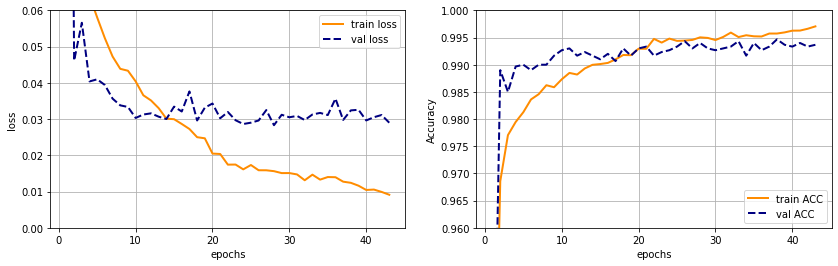

In [12]:
fig, ax = plt.subplots(1,2, figsize=(14,4))

ax[0].plot(epochs, train_loss, color='darkorange', lw=2, label='train loss')
ax[0].plot(epochs, val_loss, color='navy', lw=2, linestyle='--', label='val loss')
ax[0].set_ylim([0.0, 0.06])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend(loc="upper right")
ax[0].grid()

ax[1].plot(epochs, train_mae, color='darkorange', lw=2, label='train ACC')
ax[1].plot(epochs, val_mae, color='navy', lw=2, linestyle='--', label='val ACC')
ax[1].set_ylim([0.96, 1.0])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc="lower right")
ax[1].grid()

Loading the best model (with lowest `val_loss`)

In [13]:
# Clean old model and load one with the lowest validation loss
del model
keras.backend.clear_session()
model = keras.models.load_model("single_head_best_model.h5")

Lets evaluate model on the test data

In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02081848680973053
Test accuracy: 0.992900013923645


Lets analyze the misclassified images in train and test datasets


In [15]:
# Making predictions
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

print('Shape of y_pred_train: ', y_pred_train.shape)
print('Shape of y_pred_test: ', y_pred_train.shape)

Shape of y_pred_train:  (60000, 10)
Shape of y_pred_test:  (60000, 10)


In [16]:
# Choosing the most likely digit
y_pred_train = np.argmax(y_pred_train, axis=1)
y_pred_test = np.argmax(y_pred_test, axis=1)

train_label = np.argmax(y_train, axis=1)
test_label = np.argmax(y_test, axis=1)

In [17]:
# Comparing labels with the ground truth and retrieving the failed cases
failed_train = np.where(y_pred_train != train_label)[0]
failed_test = np.where(y_pred_test != test_label)[0]

print('Failed cases with train data: ', failed_train.size)
print('Failed cases with test data: ', failed_test.size)

Failed cases with train data:  94
Failed cases with test data:  71


**Train set:** Manually dividing failed cases into:
0. benign (good labels and decent quality) -> in Green
1. bad labels (good quality but mislabeled) -> in Red
2. bad quality (difficult to classify even for humans) -> in Yellow

In [7]:
bad_labels_train = np.array([1404, 5103, 6092, 7080, 7264, 10994, 14582, 15450,
                             16130, 16678, 18190, 22779, 23886, 24798, 26560,
                             26622, 28260, 28422, 32276, 32342, 35310, 35464,
                             35616, 36446, 40144, 41594, 42566, 43454, 45352,
                             46078, 46316, 47689, 50340, 51248, 52914, 53396,
                             54036, 54264, 56774, 57564, 57744, 57794, 58258,
                             59724])

bad_quality_train = np.array([80, 132, 494, 500, 788, 902, 995, 1047, 1604,
                              1940, 2554, 2676, 2720, 2764, 3532, 3692, 4476,
                              5216, 5332, 6269, 6347, 7270, 7584, 7784, 8480,
                              8670, 8729, 9433, 10800, 10944, 13508, 13558,
                              14008, 14337, 15434, 15766, 16376, 18003, 18382,
                              18609, 19360, 20350, 21766, 21944, 22200, 23089, 
                              23824, 23946, 25678, 26376, 26405, 26471, 26626,
                              26748, 26940, 29238, 30049, 31275, 32888, 33506, 
                              34750, 35246, 35480, 36104, 37038, 37834, 37838,
                              38370, 39031, 39184, 39423, 39683, 39708, 39752,
                              40386, 41284, 41396, 43109, 44262, 45917, 47759,
                              49026, 50239, 51944, 51986, 52854, 53063, 53216,
                              53638, 53806, 54097, 54458, 54756, 54834, 55340,
                              55729, 56014, 56224, 56397, 56596, 57662, 58022,
                              59701, 59719, 59720, 59731, 59747, 59915])

benign_train = np.setdiff1d(failed_train, bad_labels_train, assume_unique=True)
benign_train = np.setdiff1d(benign_train, bad_quality_train, assume_unique=True)

colors_train = { item: 'r' for item in bad_labels_train.tolist()}
colors_train.update({ item: 'y' for item in bad_quality_train.tolist()})
colors_train.update({ item: 'g' for item in benign_train.tolist()})

In [8]:
# Defing a plotting function
def plot_grid(imgs,ncol,pred_label,truth_label,ids=None,colors=None,img_size=2):
  nrow = math.ceil(imgs.shape[0]/ncol)
  fig , ax = plt.subplots(nrow, ncol, figsize=(ncol*img_size,img_size*nrow))

  for i in range(nrow):
    for j in range(ncol):

      if ncol*i + j < imgs.shape[0]:

        im = imgs[ncol*i + j]
        if im.shape[-1] == 1:
          im = np.squeeze(im)

        title = ['pred: ' + str(pred_label[ncol*i + j]) + ', truth: ' 
                  + str(truth_label[ncol*i + j])  ]#+ '\n id: ' + str(ids[ncol*i + j])]
        if nrow ==1:
          im0 = ax[j].imshow( im , cmap="gray")    
          ax[j].title.set_text(title[0])
          ax[j].set_axis_off()
          # Create a Rectangle patch
          rect = patches.Rectangle((0.25,0.25), 26.5,26.5, linewidth=4, edgecolor=colors[ids[j]], facecolor='none')
          # Add the patch to the Axes
          ax[j].add_patch(rect)
        else:
          im0 = ax[i][j].imshow( im , cmap="gray")    
          ax[i][j].title.set_text(title[0])
          ax[i][j].set_axis_off()
          # Create a Rectangle patch
          rect = patches.Rectangle((0.25,0.25), 26.5,26.5, linewidth=4, edgecolor=colors[ids[ncol*i + j]], facecolor='none')
          # Add the patch to the Axes
          ax[i][j].add_patch(rect)

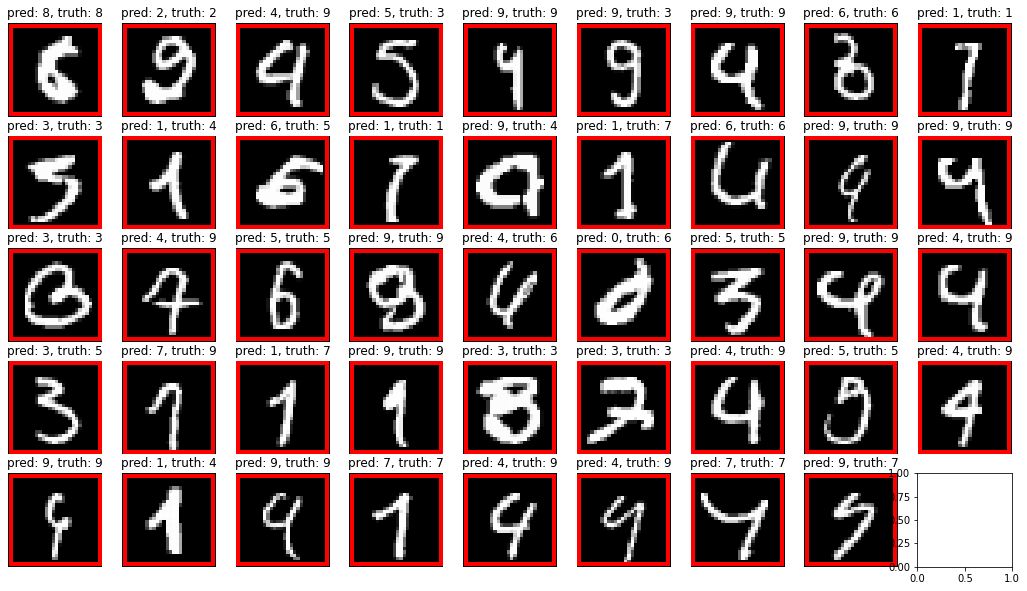

In [20]:
# Plotting the mislabeled images
plot_grid(x_train[bad_labels_train],
          ncol=9,
          pred_label  = y_pred_train[bad_labels_train].tolist(),
          truth_label = train_label[bad_labels_train].tolist(),
          ids = bad_labels_train.tolist(),
          colors = colors_train,
          img_size=2)

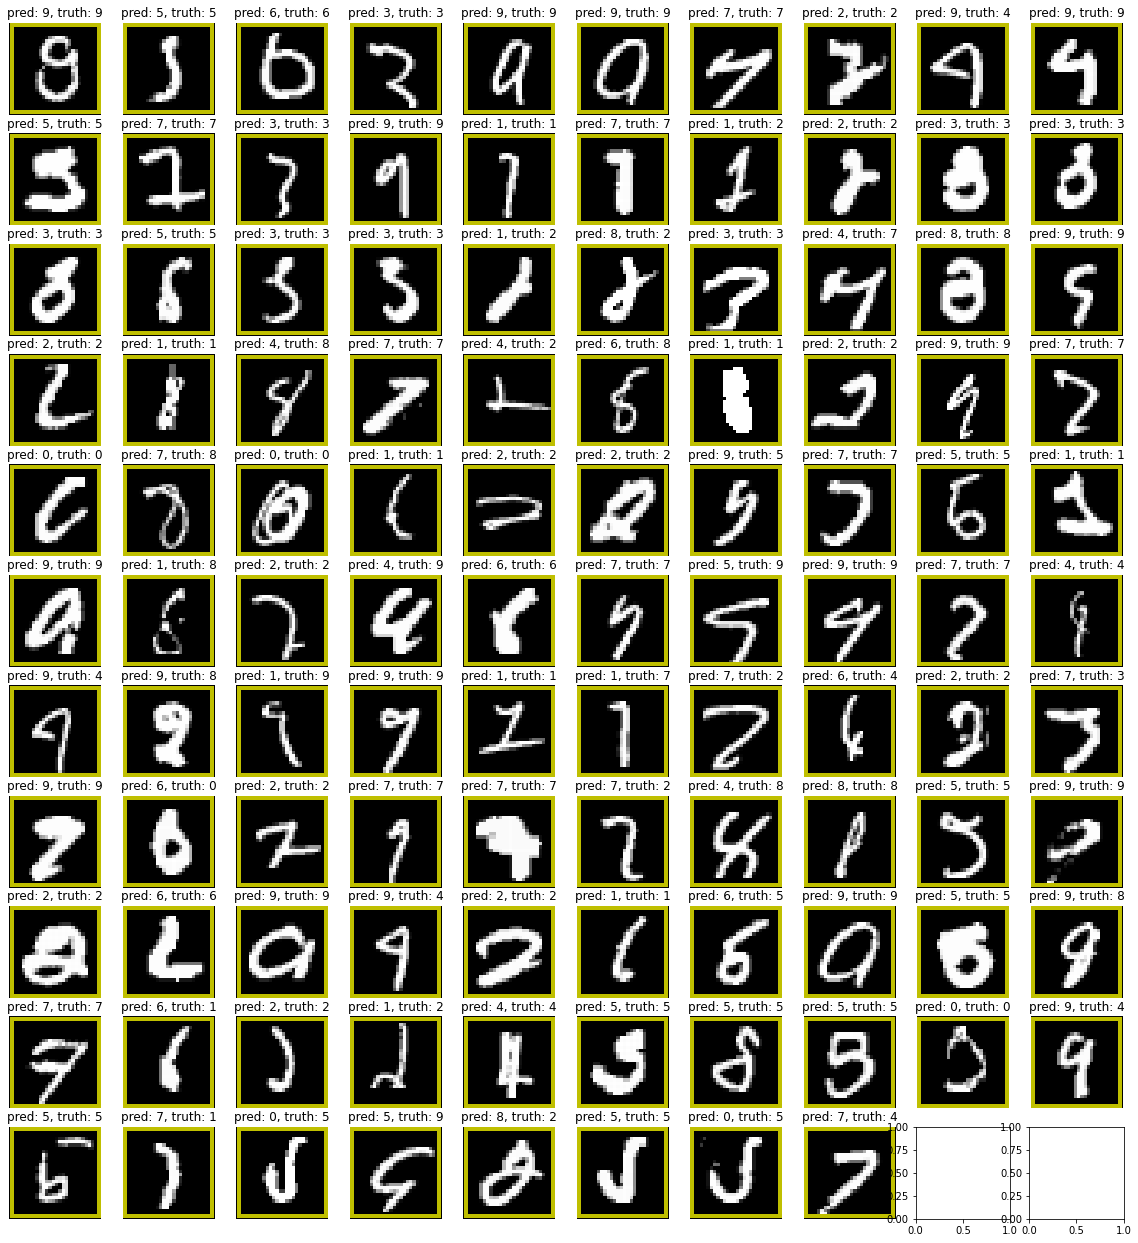

In [21]:
# Plotting the mislabeled images
plot_grid(x_train[bad_quality_train],
          ncol=10,
          pred_label  = y_pred_train[bad_quality_train].tolist(),
          truth_label = train_label[bad_quality_train].tolist(),
          ids = bad_quality_train.tolist(),
          colors = colors_train,
          img_size=2)

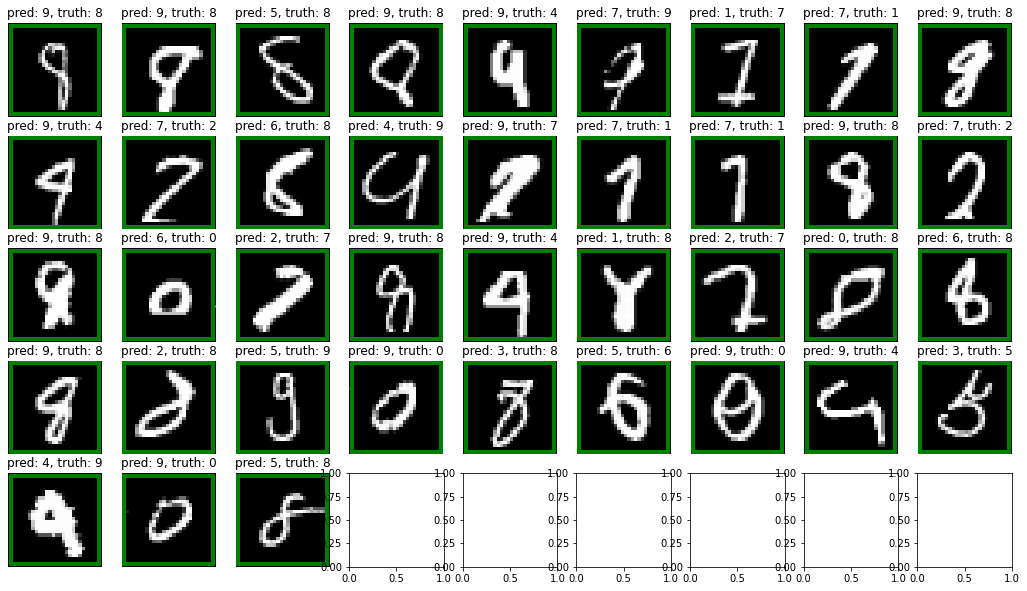

In [22]:
# Plotting the benign (misclassified) images
plot_grid(x_train[benign_train],
          ncol=9,
          pred_label  = y_pred_train[benign_train].tolist(),
          truth_label = train_label[benign_train].tolist(),
          ids = benign_train.tolist(),
          colors = colors_train,
          img_size=2)

**Test set**

In [9]:
bad_labels_test = np.array([947, 1901, 4823, 6651, 9729])

bad_quality_test = np.array([321, 340, 659, 1232, 1260, 1393, 1530, 1790, 2018,
                             2035, 2135, 2266, 2293, 2462, 2597, 2654, 2927,
                             3073, 3422, 3520, 3808, 4176, 4507, 4571, 4740, 4761, 5265, 5676, 
                             5937, 6560, 6571, 6576, 6625, 6783, 9664, 9679, 
                             9698, 9839, 9904])

benign_test = np.setdiff1d(failed_test, bad_labels_test, assume_unique=True)
benign_test = np.setdiff1d(benign_test, bad_quality_test, assume_unique=True)

colors_test = { item: 'r' for item in bad_labels_test.tolist()}
colors_test.update({ item: 'y' for item in bad_quality_test.tolist()})
colors_test.update({ item: 'g' for item in benign_test.tolist()})

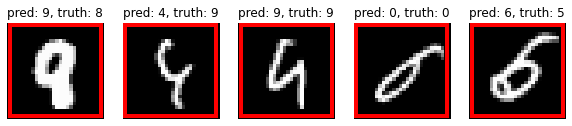

In [24]:
# Plotting the mislabeled images
plot_grid(x_test[bad_labels_test],
          ncol=5,
          pred_label  = y_pred_test[bad_labels_test].tolist(),
          truth_label = test_label[bad_labels_test].tolist(),
          ids = bad_labels_test.tolist(),
          colors = colors_test,
          img_size=2)

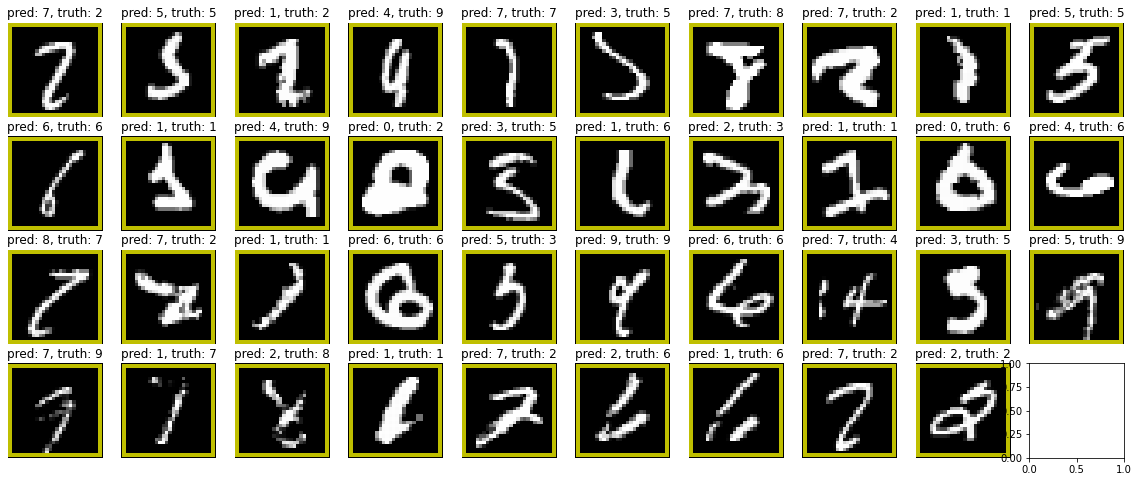

In [25]:
# Plotting the mislabeled images
plot_grid(x_test[bad_quality_test],
          ncol=10,
          pred_label  = y_pred_test[bad_quality_test].tolist(),
          truth_label = test_label[bad_quality_test].tolist(),
          ids = bad_quality_test.tolist(),
          colors = colors_test,
          img_size=2)

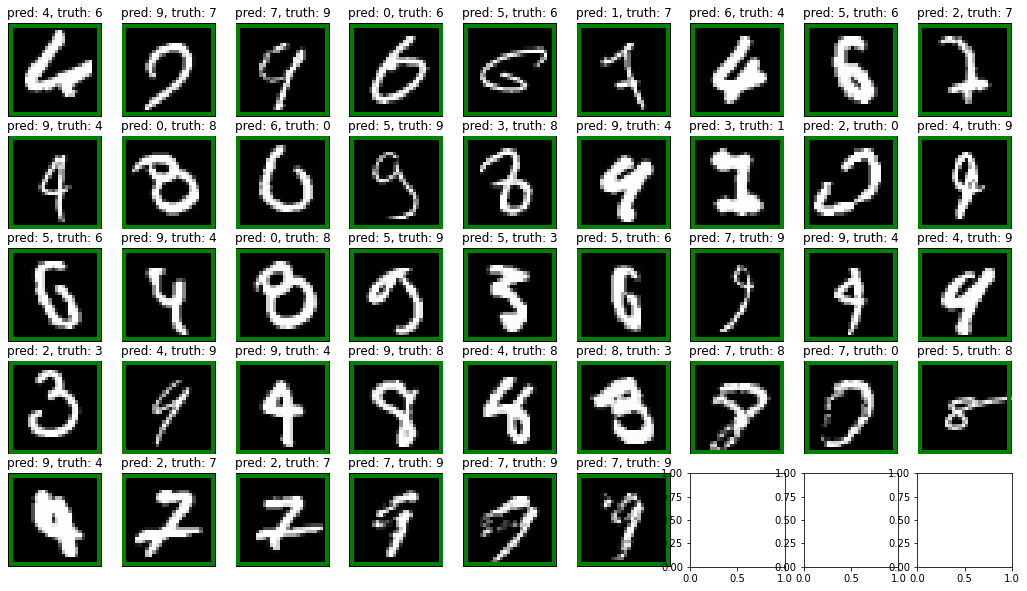

In [26]:
# Plotting the mislabeled images
plot_grid(x_test[benign_test],
          ncol=9,
          pred_label  = y_pred_test[benign_test].tolist(),
          truth_label = test_label[benign_test].tolist(),
          ids = benign_test.tolist(),
          colors = colors_test,
          img_size=2)

Dropping the mislabeled (red) and bad quality (yellow) images in the train and test datasets

In [10]:
x_train_clean = np.delete(x_train, bad_labels_train, axis=0)
x_train_clean = np.delete(x_train_clean, bad_quality_train, axis=0)

y_train_clean = np.delete(y_train, bad_labels_train, axis=0)
y_train_clean = np.delete(y_train_clean, bad_quality_train, axis=0)

print('cleaned x_train shape: ', x_train_clean.shape)
print('cleaned y_train shape: ', y_train_clean.shape)

cleaned x_train shape:  (59848, 28, 28, 1)
cleaned y_train shape:  (59848, 10)


In [11]:
x_test_clean = np.delete(x_test, bad_labels_test, axis=0)
x_test_clean = np.delete(x_test_clean, bad_quality_test, axis=0)

y_test_clean = np.delete(y_test, bad_labels_test, axis=0)
y_test_clean = np.delete(y_test_clean, bad_quality_test, axis=0)

print('cleaned x_test shape: ', x_test_clean.shape)
print('cleaned y_test shape: ', y_test_clean.shape)

cleaned x_test shape:  (9956, 28, 28, 1)
cleaned y_test shape:  (9956, 10)


Training model with the cleaned data

In [12]:
tf.random.set_seed(42)
model = get_baseline_model()
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [13]:
batch_size = 128
epochs = 100

train_history = model.fit(x_train_clean,
                          y_train_clean,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_split=0.05,
                          callbacks=callbacks)

Epoch 1/100
445/445 [==============================] - 35s 11ms/step - loss: 0.2982 - accuracy: 0.9082 - val_loss: 0.3395 - val_accuracy: 0.8904
Epoch 2/100
445/445 [==============================] - 4s 10ms/step - loss: 0.0973 - accuracy: 0.9689 - val_loss: 0.0469 - val_accuracy: 0.9863
Epoch 3/100
445/445 [==============================] - 4s 10ms/step - loss: 0.0727 - accuracy: 0.9767 - val_loss: 0.0426 - val_accuracy: 0.9903
Epoch 4/100
445/445 [==============================] - 4s 10ms/step - loss: 0.0592 - accuracy: 0.9811 - val_loss: 0.0425 - val_accuracy: 0.9913
Epoch 5/100
445/445 [==============================] - 4s 10ms/step - loss: 0.0533 - accuracy: 0.9831 - val_loss: 0.0367 - val_accuracy: 0.9916
Epoch 6/100
445/445 [==============================] - 4s 10ms/step - loss: 0.0492 - accuracy: 0.9839 - val_loss: 0.0345 - val_accuracy: 0.9916
Epoch 7/100
445/445 [==============================] - 4s 10ms/step - loss: 0.0431 - accuracy: 0.9862 - val_loss: 0.0323 - val_accuracy

In [16]:
train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
train_mae = train_history.history['accuracy']
val_mae = train_history.history['val_accuracy']
epochs = range(1,len(train_loss)+1)

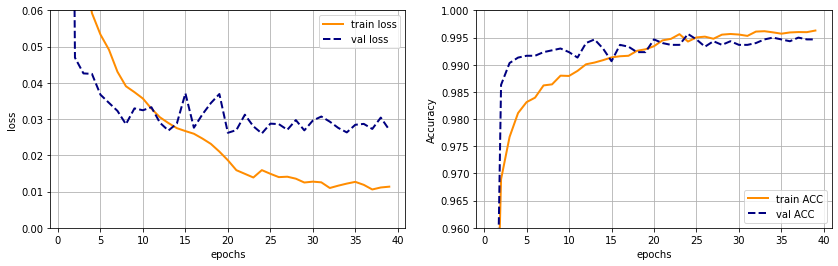

In [17]:
fig, ax = plt.subplots(1,2, figsize=(14,4))

ax[0].plot(epochs, train_loss, color='darkorange', lw=2, label='train loss')
ax[0].plot(epochs, val_loss, color='navy', lw=2, linestyle='--', label='val loss')
ax[0].set_ylim([0.0, 0.06])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend(loc="upper right")
ax[0].grid()

ax[1].plot(epochs, train_mae, color='darkorange', lw=2, label='train ACC')
ax[1].plot(epochs, val_mae, color='navy', lw=2, linestyle='--', label='val ACC')
ax[1].set_ylim([0.96, 1.0])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc="lower right")
ax[1].grid()

Evaluating the model

In [14]:
del model
keras.backend.clear_session()
model = keras.models.load_model("single_head_best_model.h5")

In [15]:
score = model.evaluate(x_test_clean, y_test_clean, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.01804094947874546
Test accuracy: 0.9938730597496033


**Conclusions:**
* We have achieved `99.29%` accuracy on the MNIST digits test set
* By manually inspecting failed casses, we have dropped `152` images (`0.25%` of data) from the train set and `44` (`0.44%` of data) images from the test set.
* After model training on the cleaned train dataset we have achieved improvement in accuracy up to `99.39%` on the cleaned MNIST digits test set.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# Convert .ipynb to .html in the Colab enviroment
%%shell
jupyter nbconvert --to html drive/MyDrive/VGTU/Deep_Learning_Systems/Lab2.ipynb

[NbConvertApp] Converting notebook drive/MyDrive/VGTU/Deep_Learning_Systems/Lab2.ipynb to html
[NbConvertApp] Writing 1031418 bytes to drive/MyDrive/VGTU/Deep_Learning_Systems/Lab2.html
